In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Estimated fs: 100.00 Hz
Reps detected: 5

 rep  dur_s  peak_dw_rad_s  mean_dw_rad_s  cv_speed  jerk_proxy  pause_count
 1   0.3600     0.5315         0.1857       0.7543    18.2062        1      
 2   3.1100     0.9528         0.2519       0.4886    40.0574        6      
 3   3.9200     0.4532         0.1686       0.3229     9.8217        5      
 4   1.6500     0.4016         0.1639       0.4377     5.3814        2      
 5   1.2300     0.3760         0.1772       0.4217     4.3672        1      

Interpretation tips:
- Lower cv_speed  -> smoother speed profile
- Lower jerk_proxy -> fewer abrupt changes
- pause_count > 0 -> hesitation within rep


C:\Users\dipes\AppData\Local\Temp\ipykernel_47632\2984592895.py:102: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  jerk_energy = float(np.trapz(dv**2, tt))


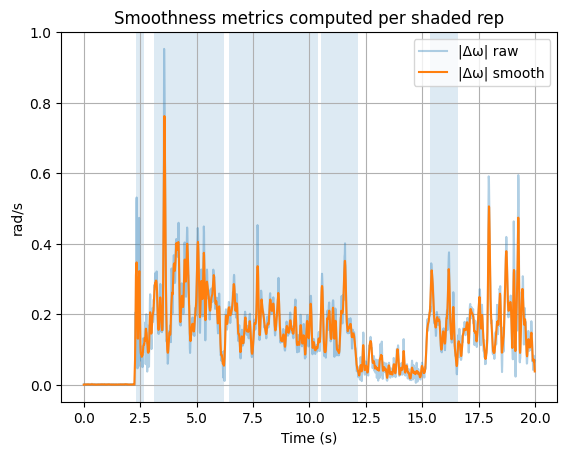

In [2]:
CSV_PATH = "dual_mpu_capture.csv"

# ---------- Segmentation tunables (same as ROM step) ----------
SMOOTH_WIN = 7
START_THR = 0.22
STOP_THR  = 0.12
MIN_REP_DUR_S = 0.35
MIN_REST_S    = 0.15
# -------------------------------------------------------------

# ---------- Smoothness tunables ----------
PAUSE_THR_RATIO = 0.35   # pause if |Δω| < (ratio * rep_peak)
PAUSE_MIN_MS    = 120    # minimum pause duration to count (ms)
# ----------------------------------------

def moving_avg(x, win):
    if win <= 1:
        return x.copy()
    k = np.ones(win) / win
    return np.convolve(x, k, mode="same")

def segment_reps(t, dw_s, fs):
    min_rep_n  = int(np.ceil(MIN_REP_DUR_S * fs))
    min_rest_n = int(np.ceil(MIN_REST_S * fs))

    reps = []
    state = 0
    rep_start_i = None
    peak_i = None
    peak_val = -np.inf
    below_count = 0

    for i, v in enumerate(dw_s):
        if state == 0:
            if v >= START_THR:
                state = 1
                rep_start_i = i
                peak_i = i
                peak_val = v
                below_count = 0

        elif state == 1:
            if v > peak_val:
                peak_val = v
                peak_i = i

            if v <= STOP_THR:
                below_count += 1
                if below_count >= min_rest_n:
                    rep_end_i = i
                    if rep_end_i - rep_start_i >= min_rep_n:
                        reps.append({
                            "start_i": rep_start_i,
                            "end_i": rep_end_i,
                            "peak_i": peak_i,
                            "peak_val": float(peak_val),
                        })
                    state = 0
                    rep_start_i = None
                    peak_i = None
                    peak_val = -np.inf
                    below_count = 0
            else:
                below_count = 0
    return reps

def main():
    df = pd.read_csv(CSV_PATH)
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna().reset_index(drop=True)

    # Time axis
    t = (df["T_US"] - df["T_US"].iloc[0]) / 1e6
    t = t.to_numpy()
    dt = np.median(np.diff(t))
    fs = 1.0 / dt if dt > 0 else 100.0

    # Relative angular velocity
    w1 = df[["G1X","G1Y","G1Z"]].to_numpy()
    w2 = df[["G2X","G2Y","G2Z"]].to_numpy()
    dw_mag = np.linalg.norm(w1 - w2, axis=1)
    dw_s   = moving_avg(dw_mag, SMOOTH_WIN)

    # Segment reps
    reps = segment_reps(t, dw_s, fs)

    rows = []

    for k, r in enumerate(reps, 1):
        si, ei = r["start_i"], r["end_i"]
        tt = t[si:ei+1]
        yy = dw_mag[si:ei+1]

        # ---------- Speed variability ----------
        mean_v = np.mean(yy)
        std_v  = np.std(yy)
        cv_v   = std_v / mean_v if mean_v > 1e-6 else np.nan

        # ---------- Jerk proxy ----------
        dv = np.gradient(yy, tt)
        jerk_energy = float(np.trapz(dv**2, tt))

        # ---------- Pause / hesitation count ----------
        peak = np.max(yy)
        pause_thr = PAUSE_THR_RATIO * peak
        below = yy < pause_thr

        min_pause_n = int(np.ceil((PAUSE_MIN_MS / 1000.0) * fs))
        pauses = 0
        run = 0
        for b in below:
            if b:
                run += 1
                if run == min_pause_n:
                    pauses += 1
            else:
                run = 0

        rows.append({
            "rep": k,
            "dur_s": float(tt[-1] - tt[0]),
            "peak_dw_rad_s": float(peak),
            "mean_dw_rad_s": float(mean_v),
            "cv_speed": float(cv_v),
            "jerk_proxy": jerk_energy,
            "pause_count": pauses,
        })

    out = pd.DataFrame(rows)

    print(f"Estimated fs: {fs:.2f} Hz")
    print(f"Reps detected: {len(out)}\n")

    if len(out):
        print(out.to_string(index=False, justify="center",
                            float_format=lambda x: f"{x:.4f}"))
        print("\nInterpretation tips:")
        print("- Lower cv_speed  -> smoother speed profile")
        print("- Lower jerk_proxy -> fewer abrupt changes")
        print("- pause_count > 0 -> hesitation within rep")
    else:
        print("No reps detected.")

    # ---------- Diagnostic plot ----------
    plt.figure()
    plt.plot(t, dw_mag, alpha=0.35, label="|Δω| raw")
    plt.plot(t, dw_s, label="|Δω| smooth")
    for r in reps:
        plt.axvspan(t[r["start_i"]], t[r["end_i"]], alpha=0.15)
    plt.title("Smoothness metrics computed per shaded rep")
    plt.xlabel("Time (s)")
    plt.ylabel("rad/s")
    plt.grid(True)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()